<a href="https://colab.research.google.com/github/AnabelleSouza/CRUD_PDO-CONTEINER/blob/main/Real_Estate_Valuation_2ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
pip install ucimlrepo

In [43]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

# data (as pandas dataframes)
X = real_estate_valuation.data.features
y = real_estate_valuation.data.targets

# metadata
print(real_estate_valuation.metadata)

# variable information
print(real_estate_valuation.variables)


{'uci_id': 477, 'name': 'Real Estate Valuation', 'repository_url': 'https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set', 'data_url': 'https://archive.ics.uci.edu/static/public/477/data.csv', 'abstract': 'The real estate valuation is a regression problem. The market historical data set of real estate valuation are collected from Sindian Dist., New Taipei City, Taiwan. ', 'area': 'Business', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 414, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Y house price of unit area'], 'index_col': ['No'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Mon Feb 26 2024', 'dataset_doi': '10.24432/C5J30W', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 373, 'type': 'NATIVE', 'title': 'Building real estate valuation models with comparative approach through case-based reasoning', 'authors': 'I. Yeh

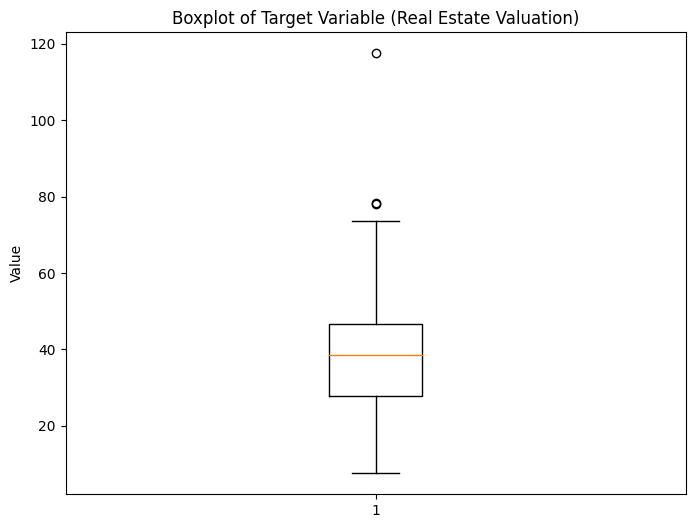

In [44]:
import matplotlib.pyplot as plt

# Plot the boxplot for the target (y) variable
plt.figure(figsize=(8, 6))
plt.boxplot(y)
plt.title('Boxplot of Target Variable (Real Estate Valuation)')
plt.ylabel('Value')
plt.show()


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az


def analise_priori(trace, y):
    fig, axes = plt.subplots(3, 2, figsize=(10, 10), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

    # Acessar os valores dos betas a partir do grupo 'prior'
    betas_values = trace.prior['betas'].values.flatten()  # Acessa os betas do grupo 'prior' e achata
    sns.histplot(betas_values, bins=20, kde=True, ax=axes[0][0])
    axes[0][0].set_xlabel("Betas")
    axes[0][0].set_ylabel("Contagem")

    # Histograma para as previsões da variável dependente (priors)
    y_obs_values = trace.prior_predictive['Y_obs'].values.flatten()  # Acessa as previsões a priori de Y_obs
    sns.histplot(y_obs_values, bins=20, kde=True, ax=axes[0][1])
    axes[0][1].set_xlabel("Previsões a Priori (Y_obs)")
    axes[0][1].set_ylabel("Contagem")

    # Previsões a priori
    prior_samples = trace.prior_predictive['Y_obs'].values  # Acessa os valores de Y_obs a partir da distribuição preditiva
    prior_samples_reshaped = prior_samples.reshape(len(y), -1)

    # Cálculo da média e desvio padrão das previsões a priori
    mean_pred = np.mean(prior_samples_reshaped, axis=1)
    std_pred = np.std(prior_samples_reshaped, axis=1)

    # Plotar as previsões médias a priori
    sns.lineplot(x=range(len(y)), y=mean_pred, ax=axes[1][0])
    axes[1][0].fill_between(range(len(y)), mean_pred - std_pred, mean_pred + std_pred, alpha=0.2)

    axes[1][0].set_title("Previsões a Priori")
    axes[1][0].set_xlabel("Observado")
    axes[1][0].set_ylabel("Previsões")
    axes[1][0].legend(['Previsões Médias'])

    # Gráficos cumulativos da priori usando Arviz
    az.plot_ppc(trace, group='prior', kind='cumulative', ax=axes[2][0], observed=True)
    az.plot_ppc(trace, group='prior', ax=axes[2][1], observed=True)

    plt.tight_layout()
    return fig, axes

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Assuming X contains the feature data
# Selecting 3 continuous features from the dataset (replace with actual column names)
features = X[['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station']]

# Scaling the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Clustering using KMeans
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Adding the cluster labels to the dataframe
X['cluster'] = clusters



<ipython-input-46-bbae2574d169>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = clusters


In [47]:
# Dropping selected columns (adjust column names based on your dataset)
X = X.drop(['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station'], axis=1)

# Creating the feature coordinates dictionary (optional)
coords = {'features': X.columns}

# Scaling the features
scaler = StandardScaler()
X_f = X.copy()
X_f = scaler.fit_transform(X)
X_f = pd.DataFrame(X_f, columns=X.columns)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = tts(X_f, y, test_size=0.3, random_state=42)

# Displaying the training data
print(X_train.head())

     X4 number of convenience stores  X5 latitude  X6 longitude   cluster
7                           0.647789     0.918898      0.581846 -0.167716
194                        -1.391638    -2.855950     -1.420941 -1.925551
19                          0.987694    -0.105692      0.499647  0.711201
176                        -1.391638    -1.642577     -2.498010 -1.925551
367                        -0.711829    -0.354175     -1.177606  0.711201


In [48]:
import ucimlrepo
import pandas as pd
import seaborn as sns
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import pytensor.tensor as tt

In [49]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [50]:
y = pd.DataFrame(y)

In [51]:
# Convert y to DataFrame and then to a NumPy array
y = pd.DataFrame(y).to_numpy().reshape(-1)

# Definir as coordenadas do modelo (quantidade de features)
coords = {'features': np.arange(X_f.shape[1])}

# Criar o modelo Ridge Bayesiano
with pm.Model(coords=coords) as model_ridge:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # Priori para os coeficientes de regressão (betas)
    betas = pm.Normal('betas', mu=0, sigma=10, dims='features')

    # Priori para o desvio padrão do erro (epsilon)
    epsilon = pm.Gamma('epsilon', alpha=2, beta=1)  # Gamma prior para epsilon

    # Definir a equação do modelo linear
    mu = alpha + pt.dot(X_f, betas)  # Substituir tt.dot por pt.dot

    # Definir a verossimilhança (Normal)
    likelihood = pm.Normal('Y_obs', mu=mu, sigma=epsilon, observed=y)

    # Amostrar da distribuição a priori (para análise a priori)
    ridge_trace_prior = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior (para ajuste do modelo)
    trace_ridge = pm.sample(1000, tune=1000, target_accept=0.95)

# Exibir o resumo dos parâmetros ajustados

az.summary(trace_ridge)

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,37.885,0.459,37.033,38.771,0.009,0.006,2653.0,1604.0,1.0
betas[0],4.370,0.571,3.284,5.428,0.013,0.009,1835.0,1505.0,1.0
betas[1],3.938,0.559,2.843,4.967,0.013,0.009,1754.0,1617.0,1.0
betas[2],3.322,0.565,2.232,4.345,0.013,0.010,1782.0,1517.0,1.0
betas[3],0.445,0.539,-0.583,1.425,0.011,0.009,2522.0,1632.0,1.0
epsilon,9.774,0.356,9.101,10.415,0.008,0.006,1846.0,1390.0,1.0


In [52]:
# Amostrar da distribuição posterior preditiva
posterior_predictive = pm.sample_posterior_predictive(trace_ridge, model=model_ridge)

 # Imprimir as chaves do posterior_predictive
print(posterior_predictive.keys())

Output()

KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)


<ipython-input-45-4581fe9e5373>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Previsões a Priori (Y_obs)', ylabel='Contagem'>],
        [<Axes: title={'center': 'Previsões a Priori'}, xlabel='Observado', ylabel='Previsões'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

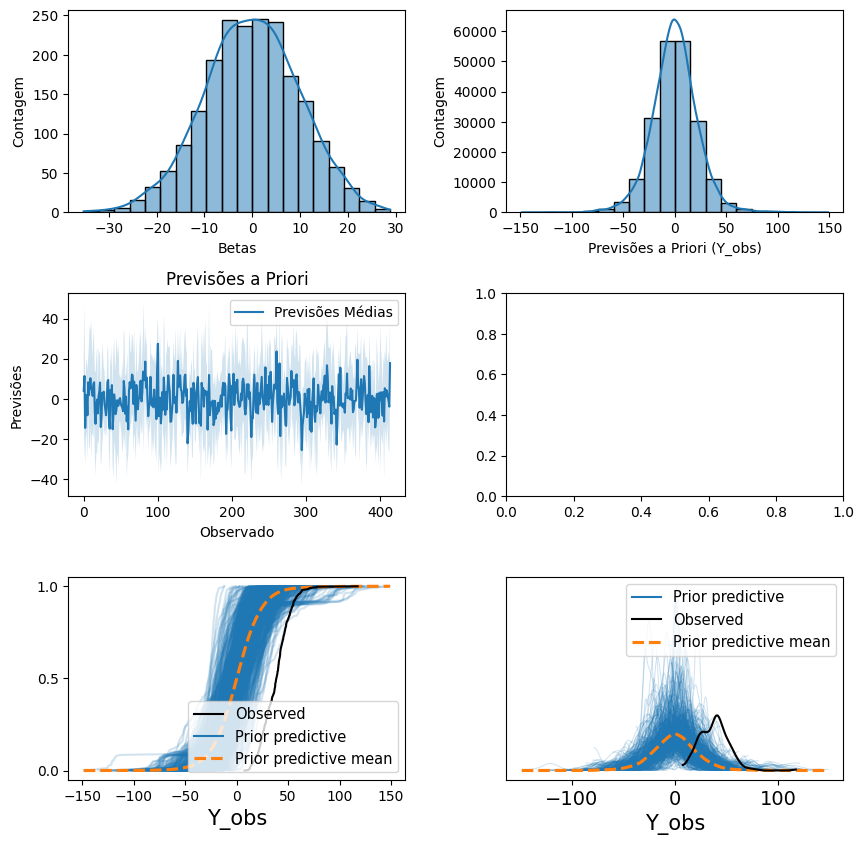

In [53]:
analise_priori(ridge_trace_prior, y)

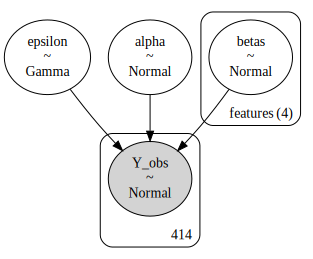

In [54]:
pm.model_to_graphviz(model_ridge)

In [55]:
def analise_posteriori(trace):
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  az.plot_ppc(trace, group='posterior', kind='cumulative', ax=axes[0]);
  az.plot_ppc(trace, group='posterior',ax=axes[1]);

  return fig, axes

Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


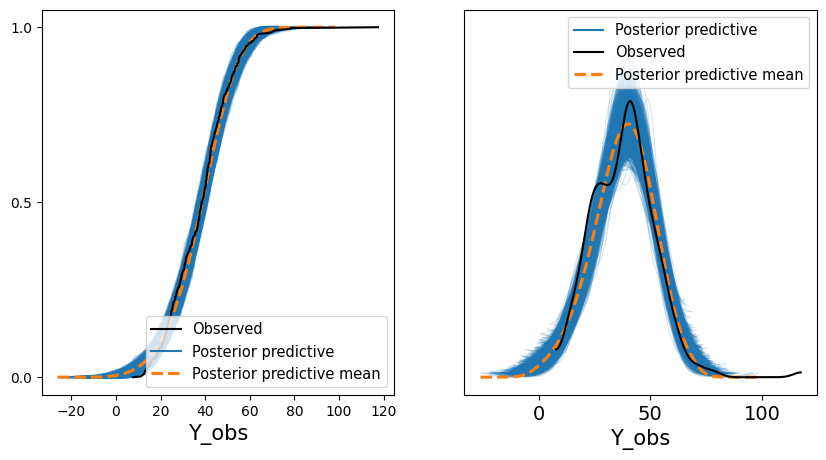

In [56]:

with model_ridge:
  trace_pos_ridge = pm.sample_posterior_predictive(trace_ridge)

analise_posteriori(trace_pos_ridge)


LASSO

In [58]:
import pymc as pm
import pytensor.tensor as pt  # Usar pytensor para a multiplicação de matrizes
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from math import sqrt

In [60]:
# Criar o modelo Lasso Bayesiano
with pm.Model(coords=coords) as model_lasso:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # Priori para os coeficientes de regressão (betas) com distribuição Laplace
    betas = pm.Laplace('betas', mu=0, b=1/sqrt(2), dims='features')  # b é o parâmetro de escala da Laplace

    # Priori para o desvio padrão do erro (epsilon)
    epsilon = pm.Gamma('epsilon', alpha=2, beta=1)

    # Definir a equação do modelo linear
    mu = alpha + pt.dot(X_f, betas)

    # Definir a verossimilhança (Normal)
    likelihood = pm.Normal('Y_obs', mu=mu, sigma=epsilon, observed=y)

    # Amostrar da distribuição a priori
    lasso_trace_prior = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior
    trace_lasso = pm.sample(1000, tune=1000, target_accept=0.95)

# Exibir o resumo dos parâmetros ajustados

az.summary(trace_lasso)

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,37.888,0.492,36.965,38.777,0.011,0.008,1880.0,1297.0,1.0
betas[0],4.186,0.570,3.123,5.224,0.013,0.009,1866.0,1514.0,1.0
betas[1],3.779,0.544,2.744,4.774,0.015,0.011,1252.0,1171.0,1.0
betas[2],3.151,0.569,2.072,4.224,0.014,0.010,1692.0,1248.0,1.0
betas[3],0.420,0.450,-0.355,1.276,0.011,0.009,1846.0,1356.0,1.0
epsilon,9.767,0.337,9.194,10.438,0.008,0.006,1673.0,1215.0,1.0


<ipython-input-45-4581fe9e5373>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Previsões a Priori (Y_obs)', ylabel='Contagem'>],
        [<Axes: title={'center': 'Previsões a Priori'}, xlabel='Observado', ylabel='Previsões'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

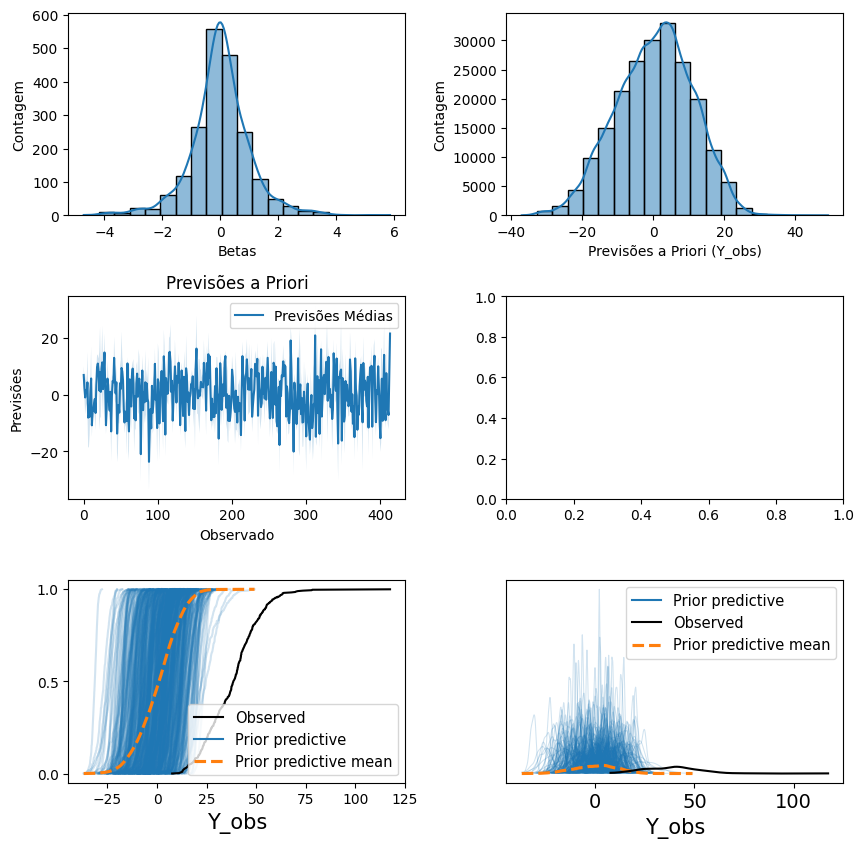

In [61]:
# Supondo que 'y' é seu vetor de dados observados
analise_priori(lasso_trace_prior, y)

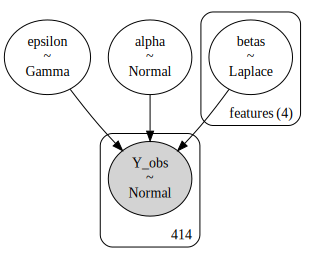

In [62]:

pm.model_to_graphviz(model_lasso)

Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


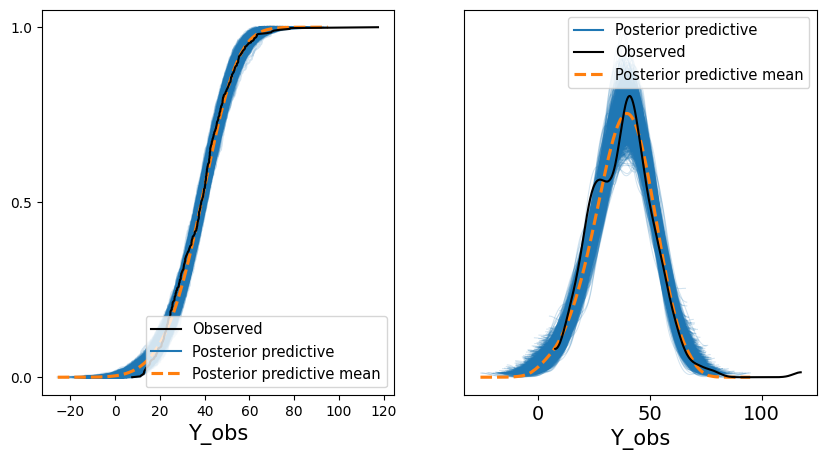

In [63]:
with model_lasso:
  trace_pos_lasso = pm.sample_posterior_predictive(trace_lasso)

analise_posteriori(trace_pos_lasso)

HIERARQUICO

In [64]:
# Criar o modelo Bayesiano Hierárquico
with pm.Model(coords=coords) as model_hierarchical:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # Priori hiperparamétrica para o desvio padrão das Laplaces dos betas
    b_hyper = pm.Gamma('b_hyper', alpha=2, beta=1)

    # Priori hierárquica para os coeficientes de regressão (betas) com distribuição Laplace
    betas = pm.Laplace('betas', mu=0, b=b_hyper, dims='features')

    # Priori hiperparamétrica para o desvio padrão do erro (epsilon)
    epsilon_hyper = pm.Gamma('epsilon_hyper', alpha=2, beta=1)
    epsilon = pm.HalfNormal('epsilon', sigma=epsilon_hyper)

    # Definir a equação do modelo linear
    mu = alpha + pt.dot(X_f, betas)

    # Definir a verossimilhança (Normal)
    likelihood = pm.Normal('Y_obs', mu=mu, sigma=epsilon, observed=y)

    # Amostrar da distribuição a priori
    trace_prior_hierarchical = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior
    trace_hierarchical = pm.sample(1000, tune=1000, target_accept=0.95)

    # Calcular log_likelihood
    pm.compute_log_likelihood(trace_hierarchical)

# Exibir o resumo dos parâmetros ajustados

az.summary(trace_hierarchical)


Output()

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,37.880,0.485,36.970,38.812,0.010,0.007,2194.0,1367.0,1.0
b_hyper,2.828,1.083,1.216,4.929,0.024,0.019,2107.0,1554.0,1.0
betas[0],4.340,0.561,3.277,5.380,0.014,0.010,1668.0,1476.0,1.0
betas[1],3.891,0.556,2.833,4.934,0.013,0.010,1711.0,1487.0,1.0
betas[2],3.274,0.623,2.117,4.446,0.014,0.010,1962.0,1541.0,1.0
betas[3],0.441,0.509,-0.484,1.434,0.012,0.010,1750.0,1287.0,1.0
epsilon,9.826,0.335,9.181,10.428,0.007,0.005,2134.0,1452.0,1.0
epsilon_hyper,5.294,1.512,2.987,8.288,0.032,0.024,2437.0,1580.0,1.0


<ipython-input-45-4581fe9e5373>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Previsões a Priori (Y_obs)', ylabel='Contagem'>],
        [<Axes: title={'center': 'Previsões a Priori'}, xlabel='Observado', ylabel='Previsões'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


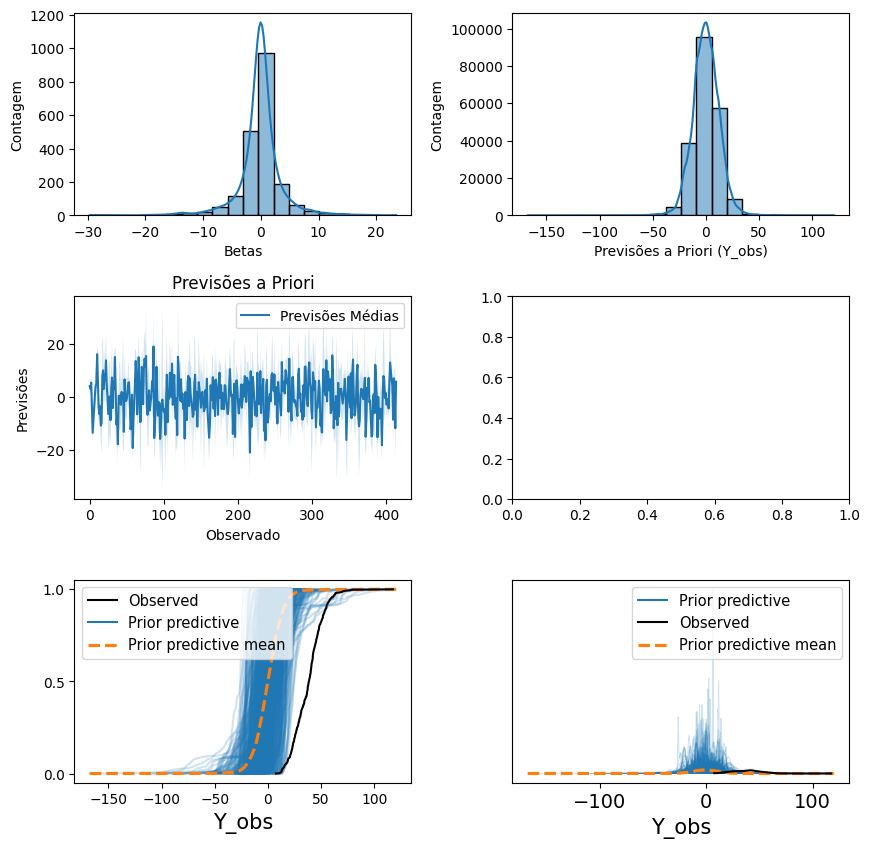

In [65]:

analise_priori(trace_prior_hierarchical,y)

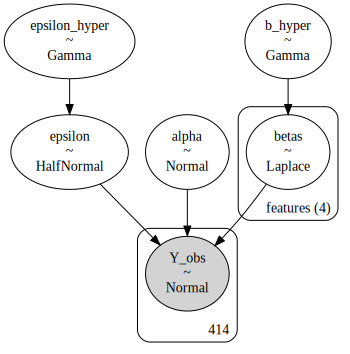

In [66]:
pm.model_to_graphviz(model_hierarchical)

Output()

<Axes: xlabel='Y_obs'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


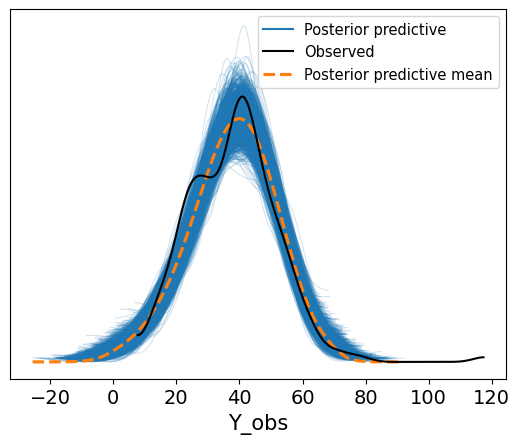

In [67]:
with model_hierarchical:
  trace_pos_hierarc = pm.sample_posterior_predictive(trace_hierarchical)


# Agora, passe o posterior_predictive para a função de análise posterior
az.plot_ppc(posterior_predictive, data_pairs={"Y_obs": "Y_obs"})

ROBUSTO

In [68]:
# Criar o modelo Bayesiano Robusto
with pm.Model(coords=coords) as model_robust:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', 0, 1)

    # Priori para os coeficientes de regressão (betas)
    betas = pm.Normal('betas', 0, 1, dims='features')

    # Priori para os graus de liberdade da distribuição Student-T (df)
    df = pm.Exponential('df', 1)

    # Definir a equação do modelo linear
    mu = alpha + pt.dot(X_f, betas)

    # Definir a verossimilhança com distribuição Student-T
    likelihood = pm.StudentT('Y_obs', nu=df, mu=mu, observed=y)

    # Amostrar da distribuição a priori
    robust_trace_prior = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior
    trace_robust = pm.sample(1000, tune=1000, target_accept=0.95)

# Exibir o resumo dos parâmetros ajustados

az.summary(trace_robust)

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,32.379,0.231,31.960,32.786,0.011,0.008,663.0,325.0,1.00
betas[0],6.099,0.242,5.691,6.538,0.012,0.009,610.0,356.0,1.01
betas[1],1.830,0.263,1.423,2.300,0.015,0.011,401.0,380.0,1.00
betas[2],2.562,0.209,2.182,2.962,0.007,0.005,1043.0,1008.0,1.00
betas[3],-0.197,0.222,-0.602,0.222,0.007,0.006,986.0,1031.0,1.00
df,0.482,0.028,0.429,0.536,0.001,0.000,1865.0,1246.0,1.00


<ipython-input-45-4581fe9e5373>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Previsões a Priori (Y_obs)', ylabel='Contagem'>],
        [<Axes: title={'center': 'Previsões a Priori'}, xlabel='Observado', ylabel='Previsões'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

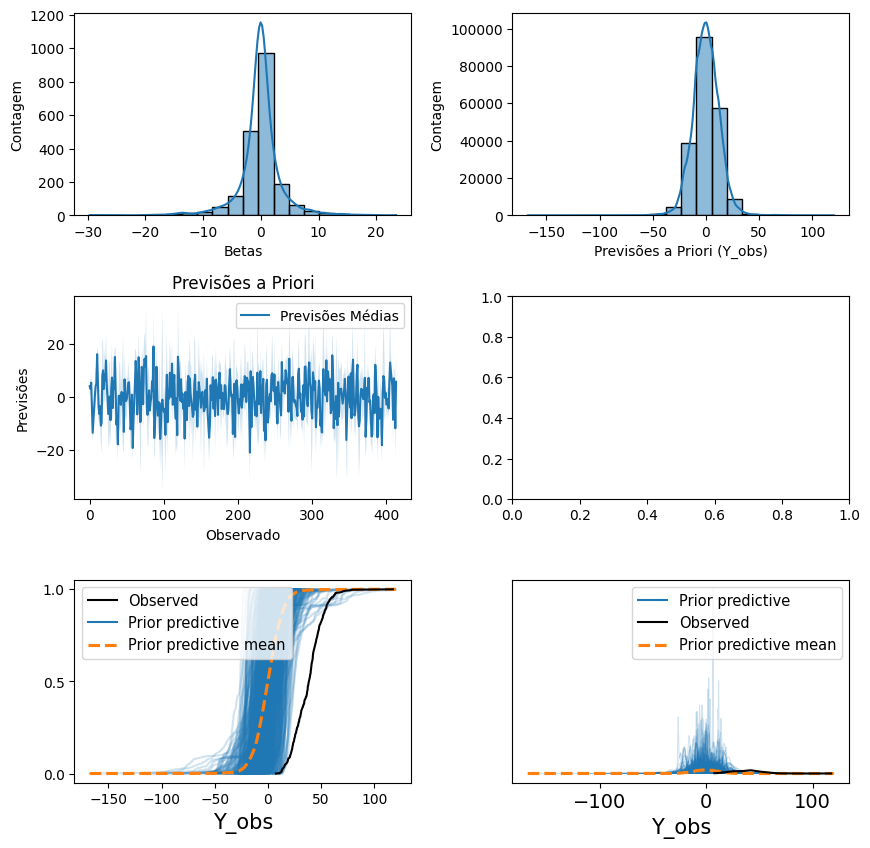

In [69]:

analise_priori(trace_prior_hierarchical,y)

/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:250: RuntimeWarning: divide by zero encountered in scalar power
  out = t - (2 * N * np.pi**0.5 * f) ** (-0.4)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


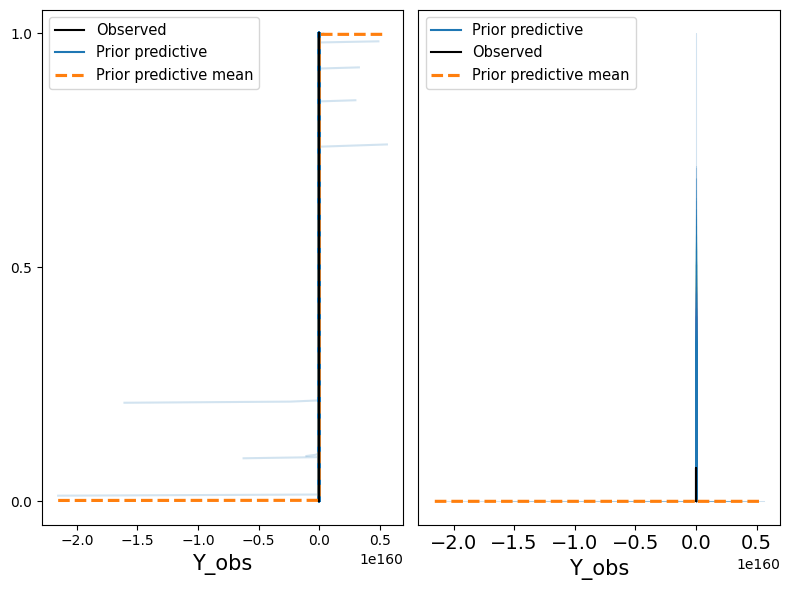

In [70]:
# Criar subplots para exibir os gráficos
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# Plotar o Posterior Predictive Check cumulativo e regular
az.plot_ppc(robust_trace_prior, group='prior', kind='cumulative', ax=axes[0], observed=True)
az.plot_ppc(robust_trace_prior, group='prior', ax=axes[1], observed=True)

# Ajustar layout
plt.tight_layout()
plt.show()

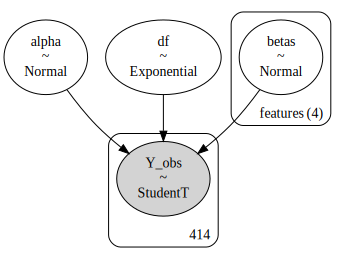

In [71]:
pm.model_to_graphviz(model_robust)

Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

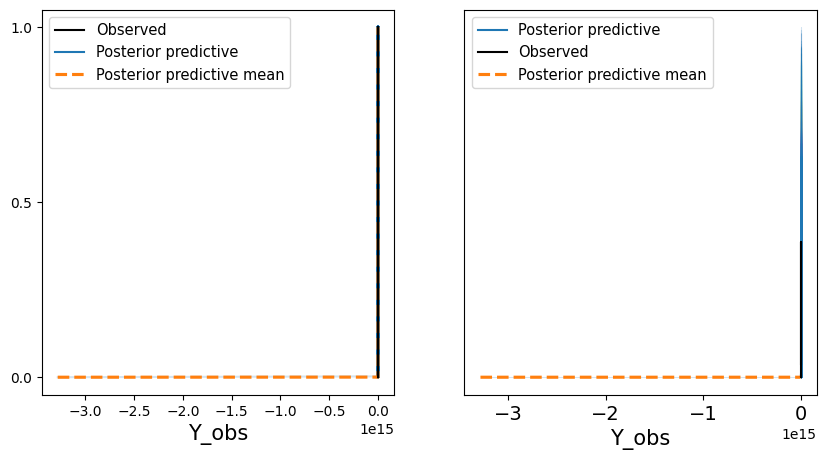

In [72]:
with model_robust:
  trace_pos_robust = pm.sample_posterior_predictive(trace_robust)

analise_posteriori(trace_pos_robust)

COMPARANDO MODELOS

In [73]:
# Verificar se o log_likelihood já existe antes de recalcular
if 'log_likelihood' not in trace_ridge.groups():
    with model_ridge:
        pm.compute_log_likelihood(trace_ridge)


if 'log_likelihood' not in trace_lasso.groups():
    with model_lasso:
        pm.compute_log_likelihood(trace_lasso)

if 'log_likelihood' not in trace_hierarchical.groups():
    with model_hierarchical:
        pm.compute_log_likelihood(trace_robust)

if 'log_likelihood' not in trace_robust.groups():
    with model_robust:
        pm.compute_log_likelihood(trace_robust)

Output()

Output()

Output()

In [74]:
# Verifique se o log_likelihood foi corretamente adicionado
print(trace_ridge.groups())

print(trace_lasso.groups())

print(trace_robust.groups())

print(trace_hierarchical.groups())

['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
['posterior', 'log_likelihood', 'sample_stats', 'observed_data']


In [75]:
import arviz as az
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the

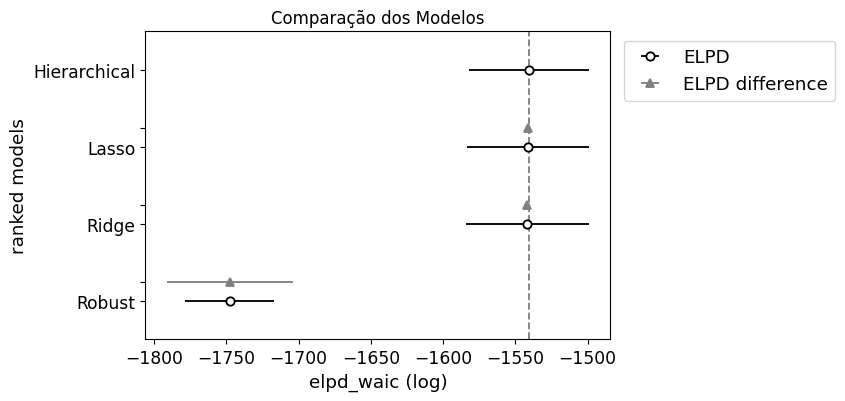

In [76]:
# Comparar os modelos usando o critério WAIC (ou LOO, se preferir)
comparison = az.compare({
    "Ridge": trace_ridge,
    "Lasso": trace_lasso,
    "Hierarchical": trace_hierarchical,
    "Robust": trace_robust
}, ic="waic")  # Você pode usar "loo" no lugar de "waic" se preferir

# Plotar a comparação
az.plot_compare(comparison)
plt.title("Comparação dos Modelos")
plt.show()
